<a href="https://colab.research.google.com/github/vnaveen97/Cost_of_Living/blob/main/Team_5_Data_Curation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

- Smoothened:
https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/
- Seasonally Adjusted:
https://www.investopedia.com/terms/s/seasonal-adjustment.asp



In [4]:
# Read all the dataframes
# All Zillow Datasets are Smoothened and Seasonally Adjusted
zillow_one_bed = pd.read_csv("/content/drive/MyDrive/Correlation One - Team 5/Datasets/Zillow Datasets/Metro_zhvi_bdrmcnt_1_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv") 
zillow_two_bed = pd.read_csv("/content/drive/MyDrive/Correlation One - Team 5/Datasets/Zillow Datasets/Metro_zhvi_bdrmcnt_2_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv")
zillow_three_bed = pd.read_csv("/content/drive/MyDrive/Correlation One - Team 5/Datasets/Zillow Datasets/Metro_zhvi_bdrmcnt_3_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv")
zillow_four_bed = pd.read_csv("/content/drive/MyDrive/Correlation One - Team 5/Datasets/Zillow Datasets/Metro_zhvi_bdrmcnt_4_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv")
zillow_five_bed = pd.read_csv("/content/drive/MyDrive/Correlation One - Team 5/Datasets/Zillow Datasets/Metro_zhvi_bdrmcnt_5_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv")
#Education Data
df_edu = pd.read_excel("/content/drive/MyDrive/Correlation One - Team 5/Datasets/ELSI - Education Data/ELSI_Education.xlsx")
#Cost of Living by City
df_COL = pd.read_csv("/content/drive/MyDrive/Correlation One - Team 5/Datasets/Numbeo - COL Index/Cost_of_living_index.csv")
#Roadway Congestion Index - Transportation Data
df_RCI = pd.read_excel("/content/drive/MyDrive/Correlation One - Team 5/Datasets/RCI/RoadwayCongestionIndex.xlsx")
#City wise Market data
df_redfin_city = pd.read_csv("/content/drive/MyDrive/Correlation One - Team 5/Datasets/Redfin City Data/city_market_tracker.csv",delimiter='\t') #pretty huge one (2.6 GBs)
#Zipcodes for each city or county level
df_zipcodes = pd.read_csv("/content/drive/MyDrive/Correlation One - Team 5/Datasets/Zipcode Database/zip_code_database.csv")
#Crimes data
df_crime = pd.read_excel("/content/drive/MyDrive/Correlation One - Team 5/Datasets/Crimes/Crimes.xlsx")

In [5]:
# Zillow Analysis

**Zillow**

In [6]:
# Concatenating all the five Zillow dfs
dfs = [zillow_one_bed,zillow_two_bed,zillow_three_bed,zillow_four_bed,zillow_five_bed]
zillow = pd.DataFrame()
def merge_zillow(dfs):
  for i,df in enumerate(dfs):
    df = df.melt(id_vars=["RegionID", "SizeRank","RegionName","RegionType","StateName"], 
            var_name="Date", 
            value_name="Typical Home Value")
    df['RegionIDBed'] = df['RegionID'].map(str) + "_" + str(i+1) # Creating a new column to distinguish each df
    # print(df)
    global zillow
    zillow = zillow.append(df)
  return zillow
zillow_df = merge_zillow(dfs)

In [7]:
print("shape of Zillow df:",zillow_df.shape)
zillow_df.tail()

shape of Zillow df: (1183680, 8)


,RegionID,SizeRank,RegionName,RegionType,StateName,Date,Typical Home Value,RegionIDBed
237827,394342,919,"Atchison, KS",msa,KS,2022-10-31,264707.0,394342_5
237828,395111,920,"Spencer, IA",msa,IA,2022-10-31,276166.0,395111_5
237829,395186,922,"Vermillion, SD",msa,SD,2022-10-31,346330.0,395186_5
237830,394743,924,"Ketchikan, AK",msa,AK,2022-10-31,521742.0,394743_5
237831,753874,925,"Craig, CO",msa,CO,2022-10-31,398235.0,753874_5


- RegionID: Unique identifier assigned to each city
- MSA: Metropolitan Statistical Area - CAN DROP
- Size Rank: Artibitrary ranking given to the metro area by Zillow - CAN DROP





<Figure size 288x216 with 0 Axes>

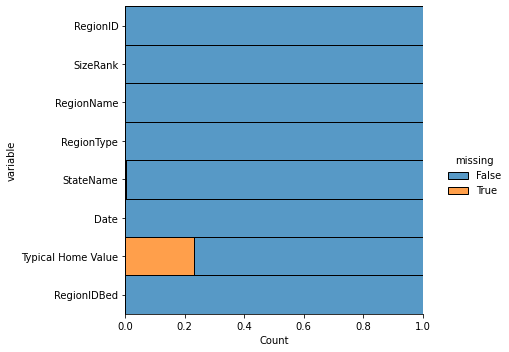

In [8]:
def missing_data(df): #func to plot the missing data in a df
  plt.figure(figsize=(4,3))
  sns.displot(data=df.isna().melt(value_name="missing"),y="variable",hue="missing",multiple="fill",aspect=1.25)
missing_data(zillow_df)

In [9]:
# Missing data
zillow_df['Typical Home Value'].isna().value_counts()

False    910212
True     273468
Name: Typical Home Value, dtype: int64

In [10]:
zillow_df['RegionName'] = zillow_df['RegionName'].str.split(',',1).str[0] #stripping the state info from RegionName as it less useful and doesn't follow with standard db protocols 
# The Date contains only the last day of every month, so it might be useful to keep only the year and the month e.g., '2001-01'
zillow_df['Date'] = pd.to_datetime(zillow_df['Date']).dt.to_period('M')
# zillow_df

In [11]:
missing_zillow_df = pd.DataFrame(zillow_df[zillow_df['Typical Home Value'].isna()].groupby(by=['RegionName'])['RegionID'].count())
total_zillow_df = pd.DataFrame(zillow_df.groupby(by=['RegionName'])['RegionID'].count())
merged_zillow_df = total_zillow_df.merge(missing_zillow_df,how='outer',on='RegionName').reset_index()
merged_zillow_df = merged_zillow_df.rename(columns={'RegionID_x': 'Total Count of Home Values','RegionID_y':'Missing Count of Home Values'})
merged_zillow_df['percentage of missing'] = (merged_zillow_df['Missing Count of Home Values']/merged_zillow_df['Total Count of Home Values'])*100

#Remove regions where missing values are greater than 25% and store their names in a list so that we can remove them from other dfs if needed
region_list_rem = list(merged_zillow_df[merged_zillow_df['percentage of missing'] > 25]['RegionName'])

zillow_df = zillow_df[~zillow_df['RegionName'].isin(region_list_rem)] 
#drops around 12.8% of the records from the df (1183680 - 1032158)/1183680

In [12]:
# Replace outliers - maybe this week or later - remember we are only looking at a handful of cities

In [13]:
# Replace missing values

zillow_df['Typical Home Value'] = zillow_df['Typical Home Value'].ffill().bfill()
zillow_df['Typical Home Value'].isna().value_counts()


False    670478
Name: Typical Home Value, dtype: int64

In [14]:
zillow_df['RegionID'] = zillow_df['RegionID'].astype(str)

#drop unneccessary columns
zillow_df = zillow_df.drop(columns=['SizeRank', 'RegionType']) 

In [15]:
#Only include RegionIDs for NY, SF, Chi, Dal, Houston, Phx
city_list = ['New York','San Francisco','Chicago','Dallas','Houston','Phoenix']

cities_key = zillow_df[zillow_df["RegionName"].isin(city_list)]
#cities_unique = cities_key.nunique()           #--> confirmed only 1 UID for each key city, and 5 RegionIDBed for each key city
#cities_unique.drop_duplicates('RegionName')   #RegionIDs are as follows: 394913, 394463, 394514, 394692, 394976, 395057

cities_key['Year'] = cities_key['Date'].dt.year
cities_key = cities_key[cities_key['Year'] == 2022]
#cities_unique = cities_unique.groupby('RegionIDBed').mean()
cities_key = cities_key.sort_values('RegionID')
cities_key = cities_key.groupby(['RegionIDBed','RegionName','StateName'])['Typical Home Value'].mean()
cities_key_df = pd.DataFrame(cities_key).reset_index()
# cities_key_df

**Cost of Living:**

In [16]:
df_COL = pd.read_csv("/content/drive/MyDrive/Correlation One - Team 5/Datasets/Numbeo - COL Index/Cost_of_living_index.csv")

df_COL[['Cities','USState_Country','Country']] = df_COL['City'].str.split(',',expand=True)

strips = ['Cities','USState_Country','Country']

for stripy in strips:
  df_COL[stripy] = df_COL[stripy].str.strip()

df_COL_US = df_COL[df_COL['Country'] == "United States"]

#Dropping Original City and Country Columns 

df_COL_US = df_COL_US.drop(['City','Country'],axis=1)
cities_COL = df_COL_US[df_COL_US["Cities"].isin(city_list)]
cities_COL

,Rank,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,Cities,USState_Country
11,12,100.00,100.00,100.00,100.00,100.00,100.00,New York,NY
13,14,96.88,106.49,101.43,101.93,94.58,125.95,San Francisco,CA
53,54,77.33,55.53,67.01,70.69,78.52,133.70,Chicago,IL
238,239,64.32,43.15,54.30,58.50,68.02,153.42,Dallas,TX
240,241,64.31,33.65,49.79,56.58,72.47,146.15,Phoenix,AZ
264,265,62.16,43.11,53.14,54.36,72.49,155.88,Houston,TX


In [17]:
cities_COL.isna().value_counts()

Rank   Cost of Living Index  Rent Index  Cost of Living Plus Rent Index  Groceries Index  Restaurant Price Index  Local Purchasing Power Index  Cities  USState_Country
False  False                 False       False                           False            False                   False                         False   False              6
dtype: int64

In [18]:
#Identify Outliers
#Identify distributions

a Rank is based on the calculated point change with the highest number corresponding to a rank of 1.										

Very large urban areas – 3 million and over population.										
Large urban areas – 1 million to less than 3 million population.										
Medium urban areas – 500,000 to less than 1 million population.										
Small urban areas – less than 500,000 population.										


$RCI:$

In [129]:
#RCI

df_RCI = pd.read_excel("/content/drive/MyDrive/Correlation One - Team 5/Datasets/RCI/RoadwayCongestionIndex.xlsx")

n=4
df_RCI.drop(columns=df_RCI.columns[-n:], axis=1,  inplace=True) # We don't need the point changes calculation, as we are going to project the data to the current years
#Also, dropping last few calculated columns 
df_RCI = df_RCI[~df_RCI['Urban area'].str.contains('averageb')]
#converting years to rows
df_RCI = df_RCI.melt(id_vars=["Urban area", "Population group"], 
            var_name="Year", 
            value_name="RCI")
df_RCI.isna().value_counts() #no missing values

Urban area  Population group  Year   RCI  
False       False             False  False    2424
dtype: int64

In [130]:
df_RCI[['City','State']] = df_RCI['Urban area'].str.split(',',expand=True)
df_RCI.drop(['Urban area'],axis=1,inplace=True)
df_RCI = df_RCI[df_RCI["City"].isin(city_list)]

In [131]:
print(df_RCI['Year'].min())
print(df_RCI['Year'].max())

1982.0
2011.0


In [132]:
# # we have the RCI data for Houston, Chicago, and Phoenix. 
# # Also the time series, starts from 1982 - 2011, we need to predict the RCI for years 2012 - 2022
# !pip install pystan~=2.14
# !pip install fbprophet

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.


                             ds      yhat  yhat_lower  yhat_upper
0 1970-01-01 00:00:00.000002012  1.136082    1.103057    1.168045
1 1970-01-01 00:00:00.000002013  1.128813    1.096729    1.160693
2 1970-01-01 00:00:00.000002014  1.121543    1.087563    1.154456
3 1970-01-01 00:00:00.000002015  1.114273    1.078102    1.145845
4 1970-01-01 00:00:00.000002016  1.107004    1.072234    1.141521


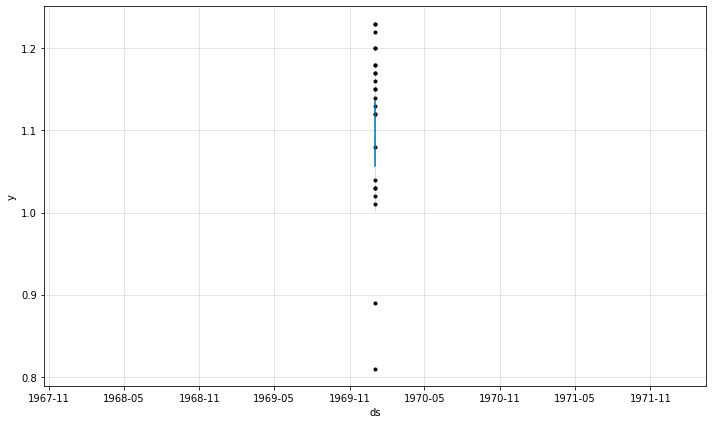

In [135]:
from fbprophet import Prophet
from matplotlib import pyplot
# load data
df_RCI = df_RCI[df_RCI['City']=='Chicago']
df_RCI_fil = df_RCI[['Year','RCI']]
df_RCI_fil['Year'] = pd.to_datetime(df_RCI_fil['Year'].format())
# prepare expected column names
df_RCI_fil.columns = ['ds', 'y']
# df_RCI_fil['ds']= pd.to_datetime(df_RCI_fil['ds'])
# define the model
model = Prophet()
# fit the model
model.fit(df_RCI_fil)
# define the period for which we want a prediction
future = list()
for i in range(1, 13):
 date = 2011 + i
 future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
pyplot.show()

In [175]:
df_RCI

,Population group,Year,RCI,City,State
21,Very large,1982.0,0.81,Chicago,IL-IN
122,Very large,1985.0,0.89,Chicago,IL-IN
223,Very large,1990.0,1.03,Chicago,IL-IN
324,Very large,1991.0,1.04,Chicago,IL-IN
425,Very large,1992.0,1.02,Chicago,IL-IN
526,Very large,1993.0,1.01,Chicago,IL-IN
627,Very large,1994.0,1.03,Chicago,IL-IN
728,Very large,1995.0,1.08,Chicago,IL-IN
829,Very large,1996.0,1.14,Chicago,IL-IN
930,Very large,1997.0,1.13,Chicago,IL-IN


$Education$

In [90]:
# † indicates that the data are not applicable.
# – indicates that the data are missing.
# ‡ indicates that the data do not meet NCES data quality standards.

In [170]:
df_edu = pd.read_excel("/content/drive/MyDrive/Correlation One - Team 5/Datasets/ELSI - Education Data/ELSI_Education_district.xlsx")
# df_edu_fil = pd.DataFrame()
# for city in city_list:
#   df_edu_fil = df_edu_fil.append(df_edu[df_edu["CBSA Name"].str.contains(city)])
df_edu['City'] = df_edu['City'].str.lower().str.title()
# df_edu_fil.reset_index(inplace=True)
df_edu = df_edu[df_edu["City"].isin(city_list)]

#collect unique latitude and longitude for each city

lat_lon = { 'dict1': {'City':'Dallas','Lat':32.779167,'Long':-96.808891},
            'dict2': {'City':'Phoenix','Lat':33.448376,'Long':-112.074036},
            'dict3': {'City':'San Francisco','Lat':37.828724,'Long':-122.355537},
            'dict4': {'City':'Chicago','Lat':41.881832,'Long':-87.623177},
            'dict5': {'City':'Houston','Lat':29.749907,'Long':-95.358421},
            'dict6': {'City':'New York','Lat':40.730610,'Long':-73.935242}
          }
lat_lon

{'dict1': {'City': 'Dallas', 'Lat': 32.779167, 'Long': -96.808891},
 'dict2': {'City': 'Phoenix', 'Lat': 33.448376, 'Long': -112.074036},
 'dict3': {'City': 'San Francisco', 'Lat': 37.828724, 'Long': -122.355537},
 'dict4': {'City': 'Chicago', 'Lat': 41.881832, 'Long': -87.623177},
 'dict5': {'City': 'Houston', 'Lat': 29.749907, 'Long': -95.358421},
 'dict6': {'City': 'New York', 'Lat': 40.73061, 'Long': -73.935242}}

In [171]:
df_edu.replace(to_replace='†',value=0,inplace=True)
df_edu.replace(to_replace='–',value=0,inplace=True)
df_edu.replace(to_replace='‡',value=0,inplace=True)
# for simplicity we are converting all missing values to zero now


In [172]:
df_edu = df_edu.drop(['County Name','Latitude','Longitude'],axis=1)
df_edu_city = df_edu.groupby(['City']).sum().reset_index()

In [174]:
df_edu_city

,City,Total Number of Public Schools,Total Students,Grades 1-8 Students,Grades 9-12 Students,Prekindergarten Students,Kindergarten Students,Male Students,Female Students,American Indian/Alaska Native Students,Asian or Asian/Pacific Islander Students,Hispanic Students,Black or African American Students,White Students,Nat. Hawaiian or Other Pacific Isl. Students,Two or More Races Students,Full-Time Equivalent (FTE) Teachers,Pupil/Teacher Ratio,Total Staff
0,Chicago,663,344735,204825,106381,11462,22067,174493,170242,954,14953,160752,123748,37836,540,5952,0.00,0.00,0.00
1,Dallas,357,200922,117366,57923,11630,14003,101948,98974,795,5141,131201,43965,16985,134,2701,13754.48,833.70,27787.52
2,Houston,774,583748,348918,166516,28927,39387,296904,286844,2708,29797,352160,127046,62222,626,9189,37190.15,662.38,78044.54
3,New York,406,167240,82262,66147,6775,9849,82203,85037,1281,19770,73893,37544,28194,585,5973,12044.56,685.84,26391.36
4,Phoenix,468,240055,150786,70196,2387,16661,122137,117918,3987,7971,132285,16785,70480,683,7864,9554.99,324.62,19935.09
5,San Francisco,133,59382,34131,20564,0,4687,30794,28578,159,19832,18894,4522,8678,469,6818,2869.67,319.04,7724.74


In [178]:
df_crime.fillna(0,inplace=True)